# Import libraries and functions

In [1]:
import torch 
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from src.dataset.tinyimagenet import TinyImageNet
from src.model.vit import vit_base
from src.model.mae import MAE
from src.utilities.reconstruct import reconstruct_image

# Prepare dataset and model

In [2]:
device = torch.device('cuda')
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

# Augmentation
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset
dataset = TinyImageNet(split='valid', transform=transform)

# Model
vit = vit_base(
    image_size=64,
    patch_size=4,
    num_classes=200,
)
mae = MAE(encoder=vit)
mae.load_state_dict(torch.load('src/checkpoints/pretrain_mae_tinyimagenet_epoch600.pth'))

mae.to(device)

MAE(
  (encoder): ViT(
    (to_patch_embedding): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=4, p2=4)
      (1): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
      (2): Linear(in_features=48, out_features=768, bias=True)
      (3): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (dropout): Dropout(p=0.0, inplace=False)
    (transformer): Transformer(
      (layers): ModuleList(
        (0-11): 12 x ModuleList(
          (0): PreNorm(
            (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (fn): Attention(
              (attend): Softmax(dim=-1)
              (dropout): Dropout(p=0.0, inplace=False)
              (to_qkv): Linear(in_features=768, out_features=2304, bias=False)
              (to_out): Sequential(
                (0): Linear(in_features=768, out_features=768, bias=True)
                (1): Dropout(p=0.0, inplace=False)
              )
            )
          )
          (1): PreNorm(


# Plot reconstructed images

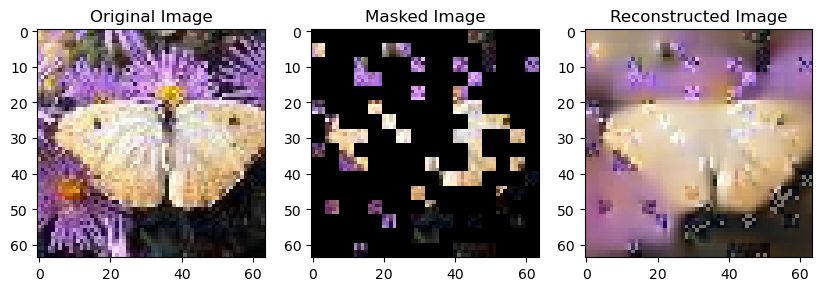

In [3]:
index = 2000

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(10,5))

# Prepare original image
sel_img = dataset[index][0]
trainer = sel_img.clone().numpy().transpose(2,1,0)
ax1.imshow(np.fliplr(np.rot90(trainer,k=3)))
ax1.set_title('Original Image')

# Prepare masked image
img = torch.unsqueeze(torch.Tensor(sel_img), 0).to(device)
loss, patches, masked_indices, pred_values = mae(img)
a = reconstruct_image(patches, img.cpu(), masked_indices, None, patch_size=4)
ax2.imshow(a[0])
ax2.set_title('Masked Image')

# Prepare reconstructed image
b = reconstruct_image(patches, img.cpu(), masked_indices, pred_values, patch_size=4)
b[0] = b[0] * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]) 
for i in range(64):
    for j in range(64):
        if (a[0][i,j,:] != np.array([0.,0.,0.])).all():
            b[0][i,j,:] = a[0][i,j,:]
ax3.imshow(b[0])
ax3.set_title('Reconstructed Image')

# Show visualisation
plt.show()